In [ ]:
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pathlib
import os

MODEL = pathlib.Path('Models', 'wall_recognizer.keras')
LABELLED = pathlib.Path('Models', 'Dataset', 'Wall Recognizer', 'Labelled')

In [ ]:
!unzip Models.zip -d .

In [ ]:
BUFFER = 128

file_paths = tf.data.Dataset.list_files(str(LABELLED/'*.png'), shuffle=False).shuffle(BUFFER, reshuffle_each_iteration=False)

In [ ]:
def parse_images(file_path):
    # extract label
    label = tf.strings.split(file_path, os.path.sep)[-1]
    label = tf.strings.split(label, '_')[:-1]
    label = tf.strings.to_number(label, tf.int32)

    # load image
    image = tf.io.read_file(file_path)
    image = tf.io.decode_png(image, channels=1)
    image = tf.image.resize(image, [28, 28])
    image = tf.cast(image, tf.float32) / 255
    return image, label

dataset = file_paths.map(parse_images)

In [ ]:
train_size = 366

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [ ]:
image = iter(train_dataset).__next__()
print(image[0].shape)

(28, 28, 1)


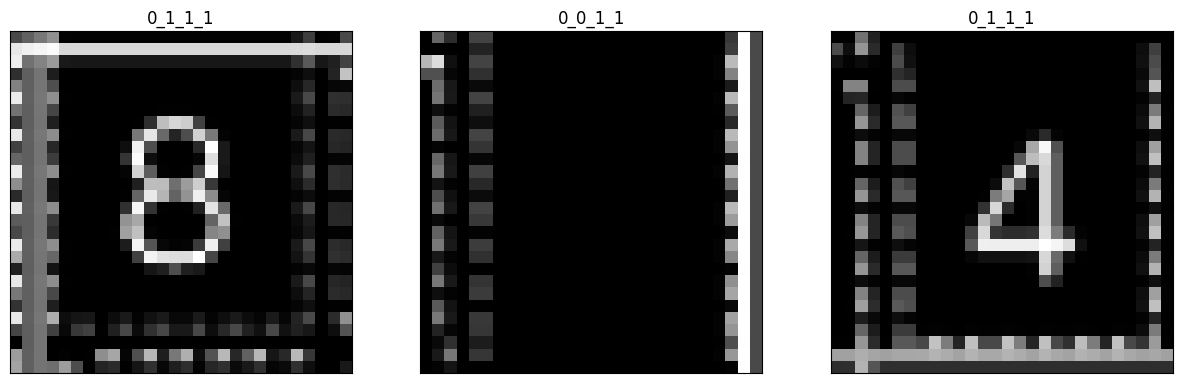

In [ ]:
plt.figure(figsize=(15, 5))
for i, (image, label) in zip(range(3), iter(train_dataset)):
    label = label.numpy().astype(np.uint8).tolist()

    plt.subplot(1, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('_'.join([str(x) for x in label]))
plt.show()

In [ ]:
train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)

In [ ]:
def get_model():
    model = keras.Sequential()

    # input layer
    model.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))

    # first convolution layer
    model.add(keras.layers.Conv2D(32, (5, 5), padding='same', kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # second convolution layer
    model.add(keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # transition to fully connected layers
    model.add(keras.layers.Flatten())

    # first dense layer
    model.add(keras.layers.Dense(64, kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.5))

    # second dense layer
    model.add(keras.layers.Dense(64, kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.5))

    # output layer
    model.add(keras.layers.Dense(4, kernel_initializer='he_uniform', activation='sigmoid'))
    return model

In [ ]:
# create a model
model = get_model()
print(model.summary())
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics='accuracy'
)

In [ ]:
model.fit(train_dataset, epochs=100, validation_data=test_dataset)

In [ ]:
model.predict(test_dataset)

1/1 [==============================] - 1s 726ms/step


array([[0.41157407, 0.5954315 , 0.5519789 , 0.41188297],
       [0.3316102 , 0.60245043, 0.4899837 , 0.33075476],
       [0.40121895, 0.6727865 , 0.5365453 , 0.45246422],
       [0.43339393, 0.63405293, 0.45812422, 0.44463336],
       [0.43232623, 0.6402574 , 0.42041963, 0.49403706],
       [0.48219615, 0.5483374 , 0.5144674 , 0.42101642],
       [0.47007573, 0.6371489 , 0.49973494, 0.415162  ],
       [0.4453054 , 0.7203568 , 0.5377953 , 0.36865112],
       [0.47074446, 0.61136055, 0.47736937, 0.46735883],
       [0.5076349 , 0.65001476, 0.43408036, 0.3849525 ],
       [0.38052103, 0.5801978 , 0.52076167, 0.45809236],
       [0.3978469 , 0.5959806 , 0.5303903 , 0.4393836 ],
       [0.4104218 , 0.64909637, 0.4980577 , 0.51226544],
       [0.39467072, 0.6261759 , 0.4177883 , 0.5768664 ],
       [0.38814965, 0.54355925, 0.5426687 , 0.37865573],
       [0.3741946 , 0.6131718 , 0.55639327, 0.39251438],
       [0.31293008, 0.49719474, 0.61615115, 0.28110167],
       [0.4679726 , 0.5938965 ,